# Introduction
Script shows how to load horizons for K2 Data and visualize them on the interpreted seismic volumes

In [1]:
import segyio
import numpy as np
import matplotlib.pyplot as plt

In [55]:
# load seismic
segy_file = segyio.open(r"E:\seismic_volumes_python\input_cubes\169394_07.lto.RTM_enhanced_far_partial_stack_OBN_TTI.6586761046_input.segy", ignore_geometry=True)

# list of all cdp_x positions
cdp_x = np.array([segy_file.header[i][segyio.TraceField.CDP_X] for i in range(0,segy_file.tracecount,10)])
unique_cdp_x = np.sort(np.unique(cdp_x))

# list of all cdp_y positions
cdp_y = np.array([segy_file.header[i][segyio.TraceField.CDP_Y] for i in range(0,segy_file.tracecount,10)])
unique_cdp_y = np.sort(np.unique(cdp_y))

# convert cdps
cdp_x = (cdp_x/100).astype(int)
cdp_y = (cdp_y/100).astype(int)
unique_cdp_x = (unique_cdp_x/100).astype(int)
unique_cdp_y = (unique_cdp_y/100).astype(int)

# list of all crossline positions
xlines = np.array([segy_file.header[i][segyio.TraceField.CROSSLINE_3D] for i in range(0,segy_file.tracecount,10)])
unique_xlines = np.unique(xlines)

# list of all inline positions
ilines = np.array([segy_file.header[i][segyio.TraceField.INLINE_3D] for i in range(0,segy_file.tracecount,10)])
unique_ilines = np.unique(ilines)

In [86]:
# read seismic by cdp_x and cdp_y positions

def segy2npy(segy_path):
    """function takes an unstructured segy file and creates a numpy array corresponding to the 3D seismic volume

    Args:
        segy_path (string): path to segy file

    Returns:
        numpy_vol (array): 3D numpy array of the form crosslines x inlines x samples representing the seismic volume
    """

    # read segy file
    segy_file = segyio.open(segy_path, ignore_geometry=True)

    # get a list of all crosslines in the file
    cdp_x = np.array([segy_file.header[i][segyio.TraceField.CDP_X] for i in range(0,segy_file.tracecount,10)])
    unique_cdp_x = np.unique(cdp_x).astype(int)

    # get a list of all inlines in the file
    cdp_y = np.array([segy_file.header[i][segyio.TraceField.CDP_Y] for i in range(0,segy_file.tracecount,10)])
    unique_cdp_y = np.unique(cdp_y).astype(int)

    # number of depth\time samples
    samples = segy_file.trace[0].size

    # create numpy array to store seismic volume
    seismic_cube = np.zeros((unique_cdp_x.size, unique_cdp_y.size, samples))

    print("Parsing Segy File...")
    for i in range(segy_file.tracecount):
        # find relative inline position for trace
        absolute_cdp_x = int(segy_file.header[i][segyio.TraceField.CDP_X])
        relative_cdp_x = np.where(unique_cdp_x==absolute_cdp_x)[0].item()

        # find relative crossline position for trace
        absolute_cdp_y = int(segy_file.header[i][segyio.TraceField.CDP_Y])
        relative_cdp_y = np.where(unique_cdp_y==absolute_cdp_y)[0].item()

        seismic_cube[relative_cdp_x, relative_cdp_y] = segy_file.trace[i]

    print("Segy parsing completed!")

    return seismic_cube

seismic = segy2npy(r"E:\seismic_volumes_python\input_cubes\169394_07.lto.RTM_enhanced_far_partial_stack_OBN_TTI.6586761046_input.segy")

Parsing Segy File...
Segy parsing completed!


In [81]:
# load horizon
horizon_file = np.genfromtxt(r"C:\Users\mustaah\OneDrive - Oxy\Downloads\MM9.txt")
x_hrz = horizon_file[1:,0].astype(int)
y_hrz = horizon_file[1:,1].astype(int)
z_hrz = (-1*horizon_file[1:,2]).astype(int)

In [82]:
# only consider points lying inside the range of the seismic
mask_valid = (x_hrz >= cdp_x.min()) & ((x_hrz <= cdp_x.max())) & (y_hrz >= cdp_y.min()) & (y_hrz <= cdp_y.max()) & (z_hrz <= segy_file.samples.max())
x_hrz = x_hrz[mask_valid]
y_hrz = y_hrz[mask_valid]
z_hrz = z_hrz[mask_valid]

In [83]:
# digitize x,y,z positions
x_inds = np.digitize(x_hrz, bins=np.sort(unique_cdp_x))
y_inds = np.digitize(y_hrz, bins=np.sort(unique_cdp_y))
z_inds = np.digitize(z_hrz, bins=np.sort(segy_file.samples))

In [84]:
# create horizon volume
horizon_vol = np.zeros((unique_cdp_x.size, unique_cdp_y.size, segy_file.samples.size+1))
horizon_vol[x_inds, y_inds, z_inds] = 1

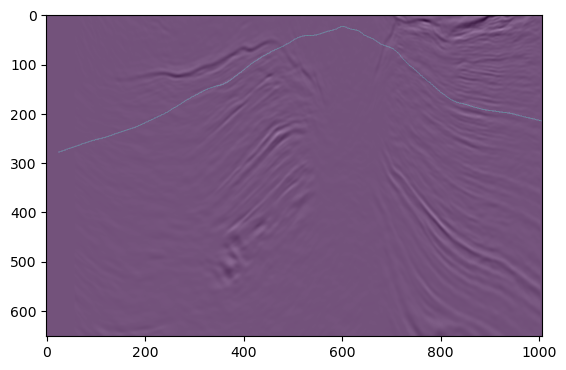

In [95]:
idx = 300
plt.imshow(seismic[:,idx,:].T, cmap='gray')
plt.imshow(horizon_vol[:,idx,:].T, alpha=0.5)
plt.show()

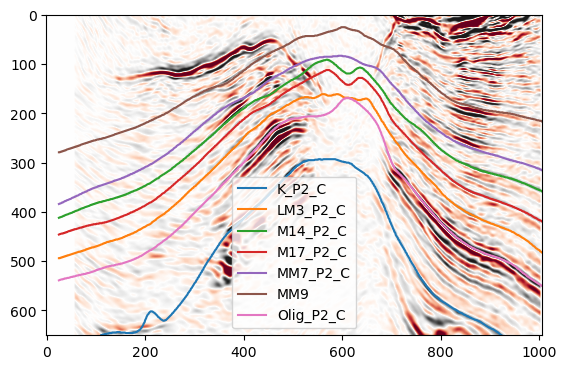

In [111]:
# plot horizons
import os
from os.path import join

def clip(array):
    std = array.std()
    return np.clip(array, -3*std, 3*std)

def plot_horizon(path_horizon_file, y_idx=300):
    
    horizon_file = np.genfromtxt(path_horizon_file)
    
    # extract horizon picks
    x_hrz = horizon_file[1:,0].astype(int)
    y_hrz = horizon_file[1:,1].astype(int)
    z_hrz = (-1*horizon_file[1:,2]).astype(int)

    # only consider points lying inside the range of the seismic
    mask_valid = (x_hrz >= cdp_x.min()) & ((x_hrz <= cdp_x.max())) & (y_hrz >= cdp_y.min()) & (y_hrz <= cdp_y.max()) & (z_hrz <= segy_file.samples.max())
    x_hrz = x_hrz[mask_valid]
    y_hrz = y_hrz[mask_valid]
    z_hrz = z_hrz[mask_valid]

    # digitize x,y,z positions
    x_inds = np.digitize(x_hrz, bins=np.sort(unique_cdp_x))
    y_inds = np.digitize(y_hrz, bins=np.sort(unique_cdp_y))
    z_inds = np.digitize(z_hrz, bins=np.sort(segy_file.samples))

    # extract picks relevant to given slice
    x_ind = x_inds[y_inds==y_idx]
    z_ind = z_inds[y_inds==y_idx]

    return x_ind, z_ind


horizon_directory = r"E:\seismic_volumes_python\horizons"
horizon_file_paths = [join(horizon_directory, file) for file in os.listdir(horizon_directory) if file.endswith('.txt')]
file_names = [os.path.splitext(os.path.basename(file_path))[0] for file_path in horizon_file_paths]

# plot horizon at this idx position
idx = 300
fig, ax = plt.subplots()
ax.imshow(clip(seismic[:,idx,:].T), cmap='RdGy')

for i, file_path in enumerate(horizon_file_paths):
    x_ind, z_ind = plot_horizon(file_path, idx)
    ax.plot(x_ind, z_ind, label=file_names[i])
plt.legend()
plt.show()

In [101]:
y_ind

array([], dtype=int64)